In [2]:
# 导入常用库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图表风格
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 替换为系统已有的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

### 读取原始数据

In [4]:
df = pd.read_csv('../Data/weather_data2024.csv')

# 查看前几行
df.head()

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622


###  数据基本信息

In [5]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Location          1000000 non-null  object 
 1   Date_Time         1000000 non-null  object 
 2   Temperature_C     1000000 non-null  float64
 3   Humidity_pct      1000000 non-null  float64
 4   Precipitation_mm  1000000 non-null  float64
 5   Wind_Speed_kmh    1000000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 45.8+ MB


Location            0
Date_Time           0
Temperature_C       0
Humidity_pct        0
Precipitation_mm    0
Wind_Speed_kmh      0
dtype: int64

### 标准化时间字段

In [6]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], errors='coerce')

# 检查是否有转换失败的项
df[df['Date_Time'].isna()]

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh


### 异常值筛选

In [7]:
# 异常值检测
# 湿度是否超过100%
df[df['Humidity_pct'] > 100]

# 气温小于 -50 的情况
df[df['Temperature_C'] < -50]


,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh


### 各变量描述性统计（按城市分组）

In [8]:

df.groupby('Location').agg({
    'Temperature_C': ['mean', 'min', 'max'],
    'Humidity_pct': ['mean'],
    'Precipitation_mm': ['sum'],
    'Wind_Speed_kmh': ['mean']
}).round(2)

# df.to_csv("城市气象统计表.csv", index=True, encoding='utf-8-sig')

Temperature_C              Humidity_pct Precipitation_mm  \
                      mean    min   max         mean              sum   
Location                                                                
Chicago              15.01 -10.00  40.0        60.09        501136.93   
Dallas               15.01 -10.00  40.0        59.96        499430.93   
Houston              14.94 -10.00  40.0        59.97        500155.54   
Los Angeles          15.08 -10.00  40.0        60.07        500058.77   
New York             15.01 -10.00  40.0        60.04        499165.85   
Philadelphia         15.04 -10.00  40.0        60.04        501467.10   
Phoenix              12.79 -19.97  40.0        60.05        610020.81   
San Antonio          15.03 -10.00  40.0        59.93        500618.82   
San Diego            14.93 -10.00  40.0        60.07        499527.82   
San Jose             14.96 -10.00  40.0        59.99        498056.57   

             Wind_Speed_kmh  
                       mean  
Location                     
Chicago               15.00  
Dallas                15.02  
Houston               14.99  
Los Angeles           15.04  
New York              14.99  
Philadelphia          14.99  
Phoenix               14.98  
San Antonio           14.96  
San Diego             15.04  
San Jose              14.97

### 箱线图查看分布

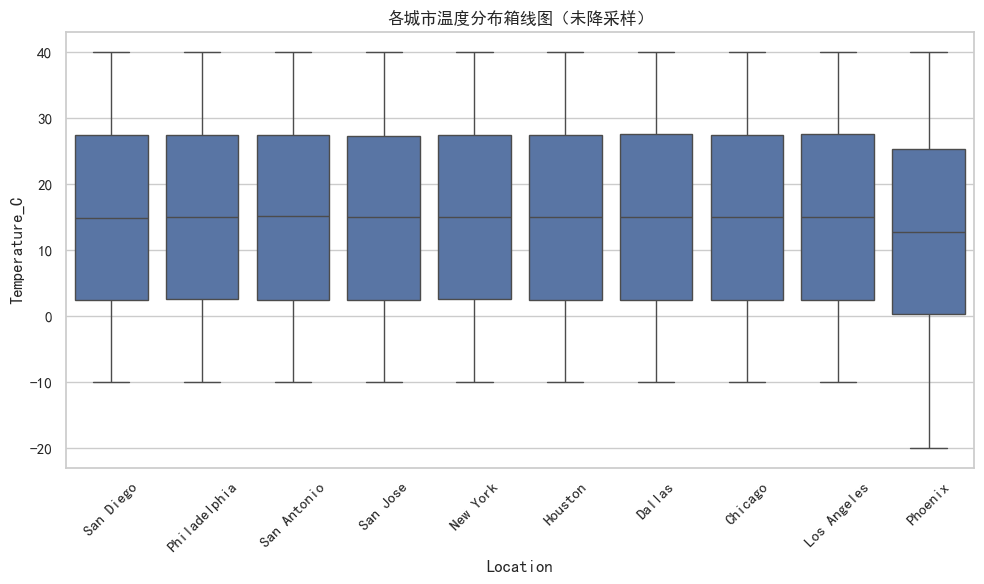

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Location', y='Temperature_C')
plt.xticks(rotation=45)
plt.title('各城市温度分布箱线图（未降采样）')
plt.tight_layout()
plt.savefig("../Figures/各城市温度分布箱线图（未降采样）.png", dpi=300)
plt.show()

### 统计所有城市的气温数据总数

In [8]:
temp_counts = df.groupby('Location')['Temperature_C'].count().reset_index(name='Temp_Data_Count')

print(temp_counts)

       Location  Temp_Data_Count
0       Chicago           100164
1        Dallas            99936
2       Houston           100076
3   Los Angeles            99922
4      New York            99972
5  Philadelphia           100122
6       Phoenix           100209
7   San Antonio            99962
8     San Diego            99774
9      San Jose            99863


In [30]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

# 选择某城市，统计一天数据条数
city = 'Chicago'
one_day = df[(df['Location'] == city) & (df['Date_Time'].dt.date == pd.to_datetime('2024-01-01').date())]
print(f"{city} 2024-01-01 数据条数: {len(one_day)}")

Chicago 2024-01-01 数据条数: 722


### 数据条数过多，按每三个小时作为采样点处理数据

In [9]:
# 转换时间格式，设定索引
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.set_index('Date_Time', inplace=True)

# 按每3小时采样，取第一个观测值
df_3h = df.resample('3H').first().reset_index()

# 创建完整的3小时时间序列，覆盖所有时间点
full_time_index = pd.date_range(start=df_3h['Date_Time'].min(), end=df_3h['Date_Time'].max(), freq='3H')
df_3h_full = pd.DataFrame({'Date_Time': full_time_index})

# 合并采样数据与完整时间序列，保留所有时间点
df_3h_full = df_3h_full.merge(df_3h, on='Date_Time', how='left')

# 对数值列做线性插值，填补缺失
value_cols = ['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']
df_3h_full[value_cols] = df_3h_full[value_cols].interpolate(method='linear')

# 前后填补可能残留的NaN值
df_3h_full[value_cols] = df_3h_full[value_cols].fillna(method='bfill').fillna(method='ffill')

# 如果 Location 列也缺失（通常只在某些时间点缺失），可以用ffill填充
df_3h_full['Location'] = df_3h_full['Location'].fillna(method='ffill').fillna(method='bfill')

# 保存为CSV
df_3h_full.to_csv('weather_data_3hourly_sample.csv', index=False)

print("3小时采样并插值后的数据已保存到 weather_data_3hourly_sample.csv")

C:\Users\35275\AppData\Local\Temp\ipykernel_1628\105343778.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_3h = df.resample('3H').first().reset_index()


3小时采样并插值后的数据已保存到 weather_data_3hourly_sample.csv


C:\Users\35275\AppData\Local\Temp\ipykernel_1628\105343778.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_index = pd.date_range(start=df_3h['Date_Time'].min(), end=df_3h['Date_Time'].max(), freq='3H')
C:\Users\35275\AppData\Local\Temp\ipykernel_1628\105343778.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_3h_full[value_cols] = df_3h_full[value_cols].fillna(method='bfill').fillna(method='ffill')
C:\Users\35275\AppData\Local\Temp\ipykernel_1628\105343778.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_3h_full['Location'] = df_3h_full['Location'].fillna(method='ffill').fillna(method='bfill')
